In [1]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential,Model,initializers,layers,Input
from tensorflow.keras.utils import plot_model

In [2]:
def Stem(input):
    x=layers.Conv2D(filters=64,kernel_size=(7,7),strides=(2,2),padding='same',activation='relu')(input)
    x=layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    x=layers.LayerNormalization()(x)
    x=layers.Conv2D(filters=192,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x)
    x=layers.Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(x)
    x=layers.LayerNormalization()(x)
    x=layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)    
    return x


def Inception(x,f1,f2,f3,f4,f5,f6):

    x1=layers.Conv2D(filters=f1,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x)
          
    x2=layers.Conv2D(filters=f2,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x)
    x2=layers.Conv2D(filters=f3,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(x2)

    x3=layers.Conv2D(filters=f4 ,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x)
    x3=layers.Conv2D(filters=f5,kernel_size=(5,5),strides=(1,1),padding='same',activation='relu')(x3)
       
    x4=layers.MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)
    x4=layers.Conv2D(filters=f6,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x4)
    
    return tf.concat([x1,x2,x3,x4],axis=3)

def AUX(input):
    ax=layers.AveragePooling2D(pool_size=(1,1),strides=(1,1))(input)
    ax=layers.Conv2D(filters=128,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(ax)
    ax=layers.Flatten()(ax)
    ax=layers.Dense(units=1024,activation='relu')(ax)
    ax=layers.Dropout(0.7)(ax)
    ax=layers.Dense(units=10,activation='softmax')(ax)
    
    return ax


def FClayer(input):
    fc=layers.AveragePooling2D(pool_size=(7,7),strides=(1,1))(input)
    fc=layers.Flatten()(fc)
    fc=layers.Dense(units=10,activation='softmax')(fc)    
    return fc

In [3]:
inputs=Input(shape=(224,224,3))
x=Stem(inputs)
x=Inception(x,256,256,256,256,256,256)
x=Inception(x,480,480,480,480,480,480)
x=layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
x=Inception(x,512,512,512,512,512,512)

ax1=AUX(x)
x=Inception(x,512,512,512,512,512,512)
x=Inception(x,512,512,512,512,512,512)
x=Inception(x,528,528,528,528,528,528)
ax2=AUX(x)
x=Inception(x,832,832,832,832,832,832)
x=layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
x=Inception(x,832,832,832,832,832,832)
x=Inception(x,1024,1024,1024,1024,1024,1024)
output=FClayer(x)
   
GooogleNet = tf.keras.models.Model(inputs,[output,ax1,ax2],name = 'GoogleNet')
model=GooogleNet

In [4]:
model.summary()

Model: "GoogleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                          

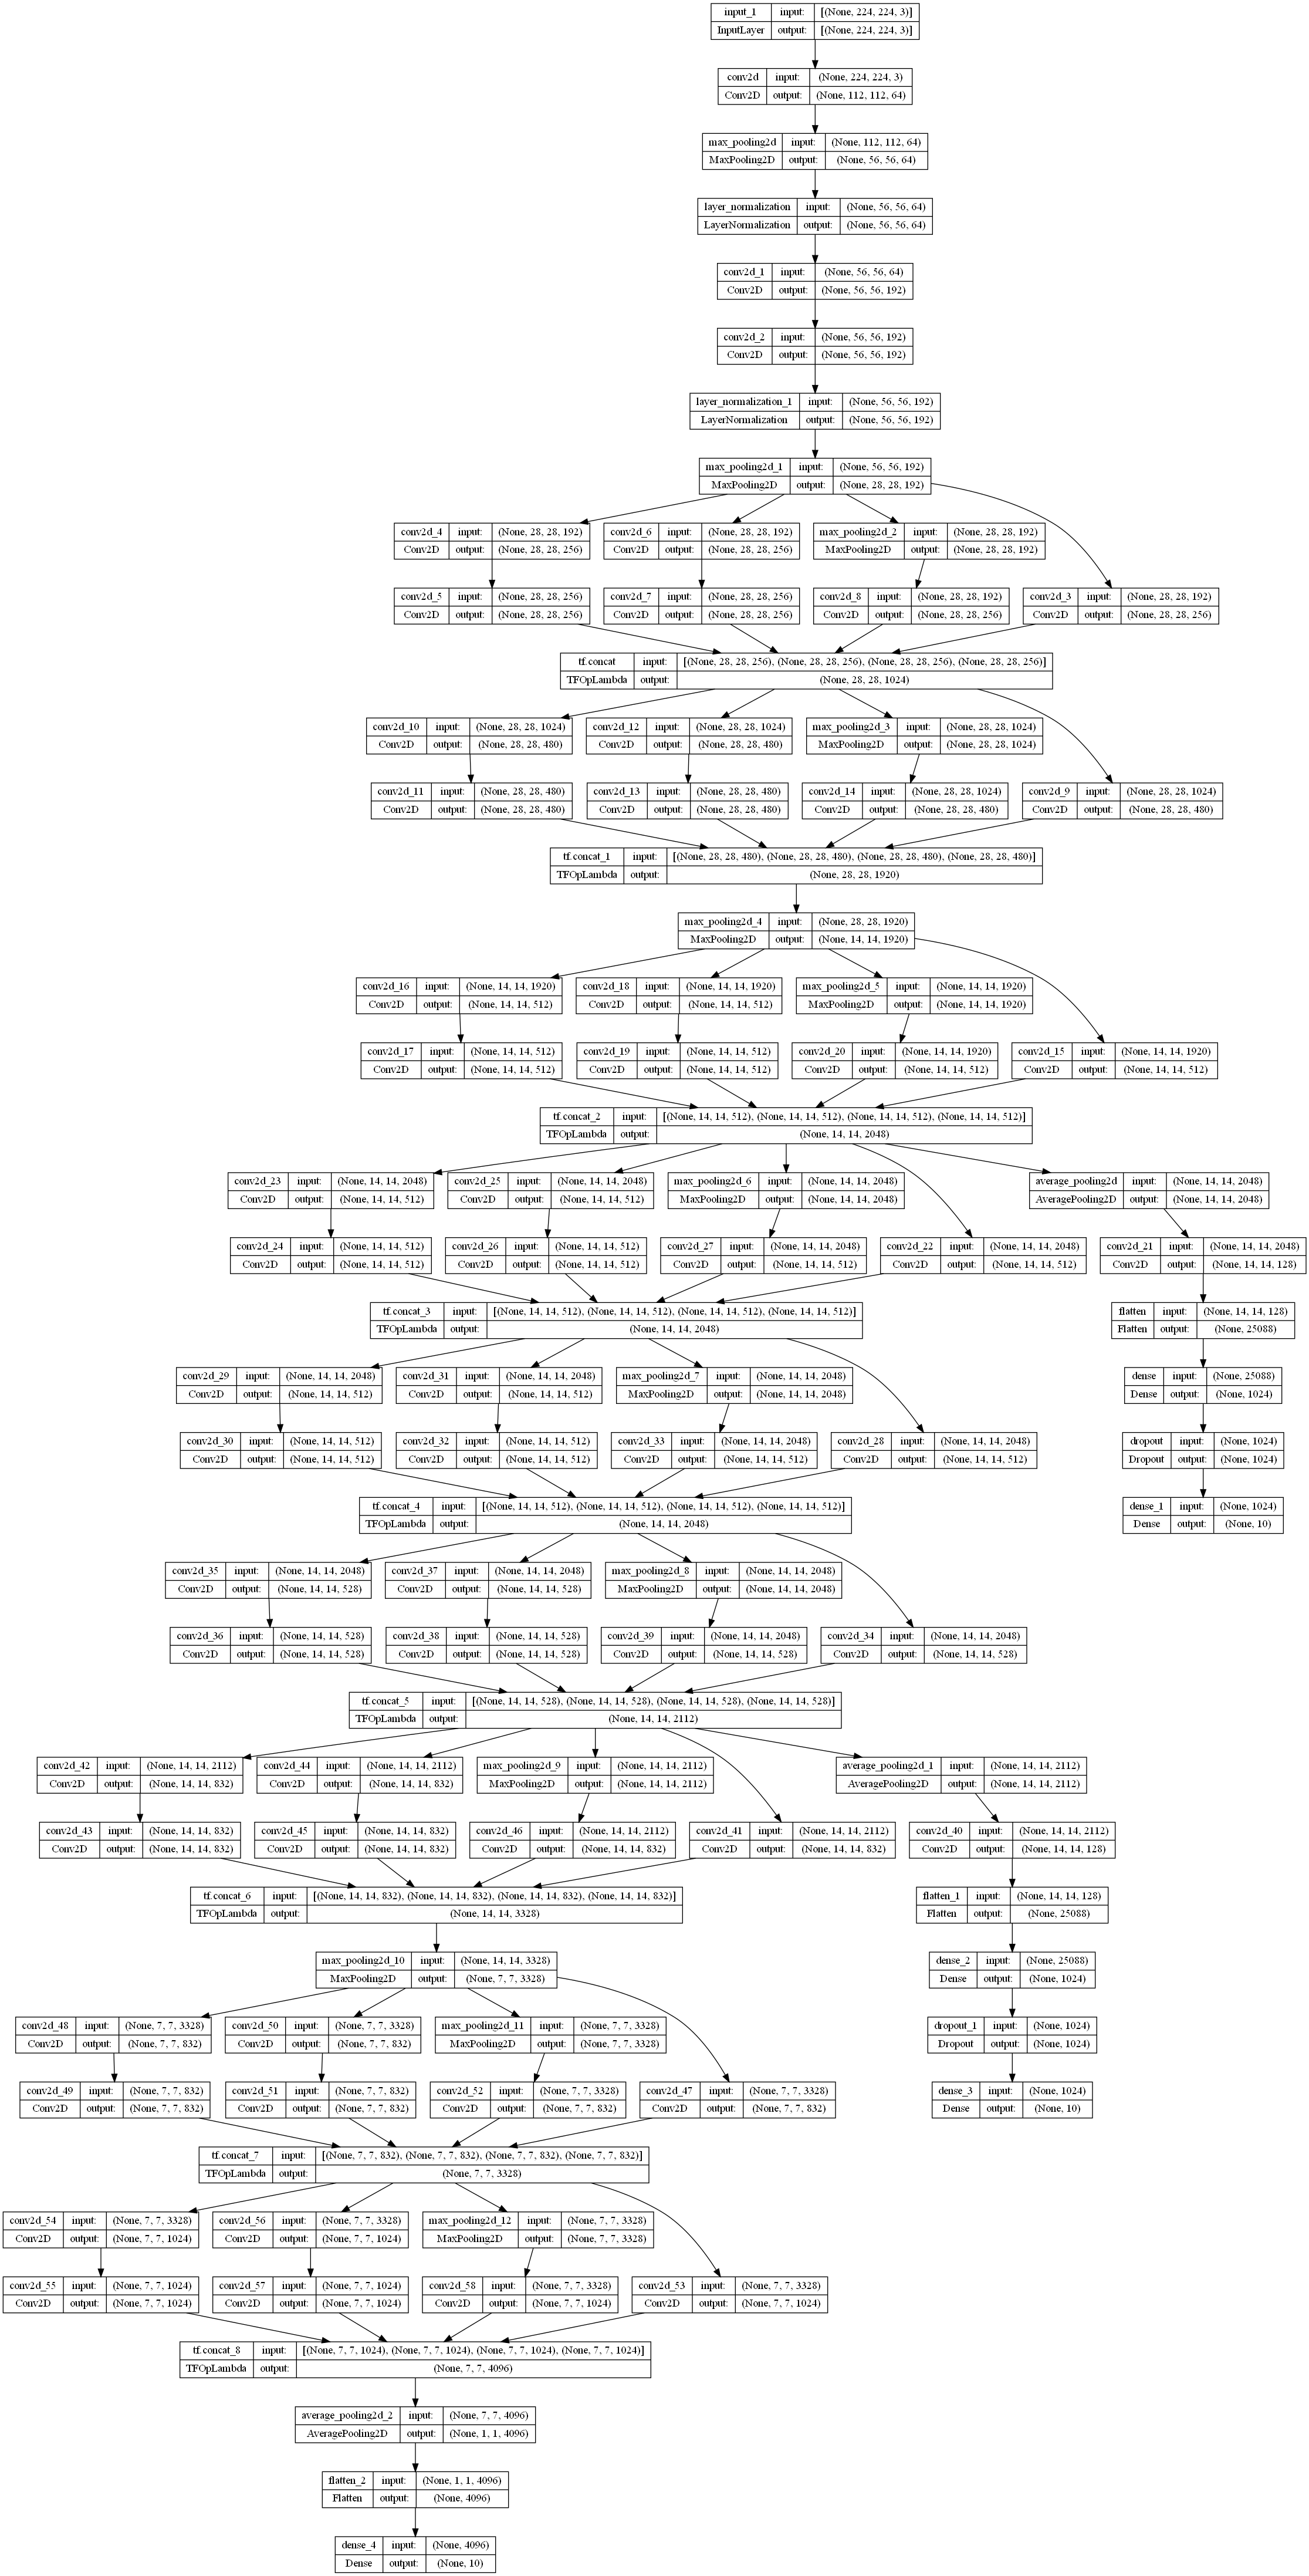

In [5]:
plot_model(model,to_file='GoogleNet.png',show_shapes=True)

In [6]:
model.compile(optimizer='adam',loss={'output':'categorical_crossentropy',
                                    'ax1' : 'categorical_crossentropy',
                                    'ax2' : 'categorical_crossentropy'},metrics=['acc'])